# Homework №3

This homework will be dedicated to Keyword Spotting (KWS), streaming and speedup NN.

# Data

In [1]:
import os
datadir = "speech_commands"

#!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
#!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls))]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


In [2]:
import pandas as pd
from tqdm import tqdm

import torchaudio
from IPython import display as display_

In [3]:
#labels = pd.DataFrame(columns=['name', 'word', 'label'])
#for el in tqdm(samples_by_target.keys()):
#    if el != '_background_noise_':
#        for name in samples_by_target[el]:
#            word = name.split('/')[1]
#            if word == 'sheila':
#                label = 1
#            elif word == 'marvin':
#                label = 2
#            else:
#                label = 0
#            labels = labels.append({'name':name, 'word':word, 'label':label}, ignore_index=True)

In [4]:
#labels.to_csv('labels.csv', index=False)

БЭКГРАУНД ЗВУКИ В АУГМЕНТАЦИЮ

In [5]:
#background_noises = pd.DataFrame(columns=['name'])

#for el in tqdm(samples_by_target.keys()):
#    if el == '_background_noise_':
#        for name in samples_by_target[el]:
#            if 'README' not in name:
#                background_noises = background_noises.append(
#                    {'name':name}, ignore_index=True
#                )

In [6]:
#background_noises.to_csv('background_noises.csv', index=False)

#background_noises = background_noises['name'].values

    Choose from 1 to 3 keywords to your liking, and use the rest as negative examples.
    We recommend to use sheila and/or marvin.

In [7]:
def add_rand_noise(audio):
    background_noises = [
        'speech_commands/_background_noise_/white_noise.wav',
       'speech_commands/_background_noise_/dude_miaowing.wav',
       'speech_commands/_background_noise_/doing_the_dishes.wav',
       'speech_commands/_background_noise_/exercise_bike.wav',
       'speech_commands/_background_noise_/pink_noise.wav',
       'speech_commands/_background_noise_/running_tap.wav'
    ]
    
    noise_num = torch.randint(low=0, high=len(background_noises), size=(1,)).item()    
    noise = torchaudio.load(background_noises[noise_num])[0].squeeze()    
    
    noize_level = torch.Tensor([1])  # [0, 40]

    noize_energy = torch.norm(noise)
    audio_energy = torch.norm(audio)

    alpha = (audio_energy / noize_energy) * torch.pow(10, -noize_level / 20)

    start = torch.randint(low=0, high=int(noise.size(0) - audio.size(0) - 1), size=(1,)).item()
    noise_sample = noise[start : start + audio.shape[0]]

    audio_new = audio + alpha * noise_sample
    audio_new.clamp_(-1, 1)
    
    return audio_new

In [8]:
#import pytorch_lightning as pl

# Model

    In this homework assignment, you will need to implement a model for finding a keyword in a stream.

        1) https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf
            It is recommended to implement the version with CNN because it is easy and improves the model.

        2) What about streaming?
           This model works differently during training and inferance.
           During training you have some fixed input and you know that it has a keyword (or not).
           During the inferance, you read the T frames and make a prediction on them. And the next step is to read the T+1 frame,
           run the neural network just for it, and make a prediction based on it and the T-1 of the previous frames.
           This way you don't make unnecessary calculations.

           So, your model should support streaming mode.
           To demonstrate the work in streaming mode, take two random audio tracks of 10-20 seconds and glue them together
           so that your keyword will be between them. Run the model through this glued track and draw how the probability of your keyword changing over time.

        3) A good KWS is a robust KWS, so we ask you to implement as many augmentations as possible.
           (bonus) Download any noise from YouTube and add it as a background noise to the positive data. This helps a lot in real life.
           P.S. Use https://www.youtube-dl.org/

        4) (bonus) Add more attentions and orthogonality regularization. https://arxiv.org/abs/1910.04500
        
        5) (bonus) Speedup you model! Implement distillation of your model, for example,
            train the LSTM with 256 hidden size and distil it into LSTM with 128 hidden size.

# Code

    1) In this homework you are allowed to use pytorch-lighting.

    2) Try to write code more structurally and cleanly!
    
    3) Good logging of experiments save your nerves and time, so we ask you to use W&B. Log loss, FA/FR rate or something else.
        Do not remove the logs until we have checked your work and given you a grade!
    
    4) (Bonus) We also ask you to organize your code in github repo with Docker and setup.py. You can use my template https://github.com/markovka17/dl-start-pack.
    
    5) Your work must be reproducable, so fix seed, save the weights of model, and etc.
    
    6) In the end of your work write inference utils. Anyone should be able to take your weight, load it into the model and run it on some audio track.

### Импорты

In [9]:
import wandb

In [10]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch import distributions


In [11]:
BATCH_SIZE = 256
NUM_EPOCHS = 35
N_MELS     = 40

### Датасеты

In [12]:
class TrainDataset(torch.utils.data.Dataset):
    """Custom competition dataset."""

    def __init__(self, root='', csv_path='labels.csv', kw='sheila', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root = root
        self.kw = kw
        self.csv = pd.read_csv(csv_path)
        self.transform = transform
        

    def __len__(self):
        return self.csv.shape[0]
    

    def __getitem__(self, idx):
        utt_name = self.root + self.csv.loc[idx, 'name']
        utt = torchaudio.load(utt_name)[0].squeeze()
        word = self.csv.loc[idx, 'word']
        label = self.csv.loc[idx, 'label']
        
        if self.transform:
            utt = self.transform(utt)

        sample = {'utt': utt, 'word': word, 'label': label}
        return sample

#### Аугментации и визуализация

In [13]:
def transform_tr(wav):
    aug_num = torch.randint(low=0, high=4, size=(1,)).item()
    augs = [
        lambda x: x,
        lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
        lambda x: torchaudio.transforms.Vol(.25)(x),
        lambda x: add_rand_noise(x)
    ]
    
    return augs[aug_num](wav)

In [14]:
def viz(wav, label):
    print(label)
    display_.display(display_.Audio(wav, rate=48000, normalize=False))

### Collate_fn и Mel'ы и датасеты


WeightedRandomSampler

In [15]:
from torch.utils.data import WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

Из-за этого ауги накладываются на валидацию тоже:

In [16]:
my_dataset = TrainDataset(csv_path='labels.csv', transform=transform_tr)
print('all train+val samples:', len(my_dataset))

all train+val samples: 64721


In [17]:
#ind = np.random.randint(0, 64721, 120)
#my_dataset = torch.utils.data.Subset(my_dataset, ind)

train_len = 57500
val_len = 64721 - train_len 
# train_len = 100
# val_len = 20
train_set, val_set = torch.utils.data.random_split(my_dataset, [train_len, val_len])

In [18]:
def get_sampler(target):
    
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])

    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    
    return sampler

In [19]:
# big
train_sampler = get_sampler(train_set.dataset.csv['label'][train_set.indices].values)
val_sampler   = get_sampler(val_set.dataset.csv['label'][val_set.indices].values)

# small
# train_sampler = get_sampler(train_set.dataset.dataset.csv['label'][train_set.indices].values)
#val_sampler   = get_sampler(val_set.dataset.dataset.csv['label'][val_set.indices].values)

In [20]:
def preprocess_data(data):
    wavs = []
    labels = []    
        
    for el in data:
        wavs.append(el['utt'])
        labels.append(el['label'])

    wavs = pad_sequence(wavs, batch_first=True)
    labels = torch.Tensor(labels).type(torch.long)
    
    return wavs, labels

###  Loading data and loaders

In [21]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=preprocess_data, 
                          sampler=train_sampler, drop_last=False,
                          num_workers=1, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=preprocess_data, 
                        sampler=val_sampler, drop_last=False,
                        num_workers=1, pin_memory=True)

### Вспомогательные функции

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
set_seed(21)

In [24]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
# with augmentations

#n_fft=1024, hop_length=256,
melspec_train = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000,  n_mels=N_MELS),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35),
).to(device)


# no augmentations
melspec_val = torchaudio.transforms.MelSpectrogram(
    sample_rate=48000,           ### 22050, 48000
    # n_fft=1024,
    # hop_length=256,
    n_mels=N_MELS
).to(device)

FA - 0, выдал 1

FR - 1, выдал 0

In [27]:
def count_FA_FR(preds, labels):
    
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    return FA.item()/torch.numel(preds), FR.item()/torch.numel(preds)

### MODEL

Есть спека размером длина аудио?

-> (BS, 40, 41), где 40 - это высота (n_mels), а 41 - 30 прошлое, 1 сейчас и 10 будущее 

**Из статьи CRNN:**

Работали с 40 x 151.

BS = 64

LR = 0.001 -> 0.0003

**Как вариант можно взять:**

out_channels = 16

GRU num_layers = 1

### WTF

 Accordingly, in the atten-
tion models, the input window has set to 189 frames to cover
the length of the wake-up word.

At runtime, the sliding window was set to 100
frames and frame shift was set to 1.

In [28]:
def sepconv(in_size, out_size, kernel_size, stride=1, dilation=1, padding=0):
    #if padding is None:
    #    padding = (kernel_size-1)//2
    return nn.Sequential(
        torch.nn.Conv1d(in_size, in_size, kernel_size[1], 
                        stride=stride[1], dilation=dilation, groups=in_size,
                        padding=padding),
        
        torch.nn.Conv1d(in_size, out_size, kernel_size=1, 
                        stride=stride[0], groups=int(in_size/kernel_size[0])),
    )

In [29]:
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
          
        self.sepconv = sepconv(in_size=40, out_size=128, kernel_size=(20, 5), stride=(8, 2))
        self.gru = nn.GRU(input_size=128, hidden_size=128, num_layers=2, dropout=0.1, bidirectional=True)
        #self.linear = nn.Linear(in_features=128, out_features=64)   # HS * num_directions
        
        
        self.init_weights()
        

    def init_weights(self):
        pass

    
    def forward(self, x, hidden):
        x = self.sepconv(x)
        
        # (BS, HS, ?) -> (HS, BS, ?) ->(seq_len, BS, HS)
        x = x.transpose(0, 1).transpose(0, 2)
        
        x, hidden = self.gru(x, hidden)
        # x : (seq_len, BS, HS * num_dirs)
        # hidden : (num_layers * num_dirs, BS, HS)
                
        #x = self.linear(x)
                        
        return x, hidden ###   #  DIM ?? ? ? ? добавить софтмакс?

In [30]:
class AttnMech(nn.Module):
    def __init__(self):
        super(AttnMech, self).__init__()
        
        self.Wx_b = nn.Linear(256, 256)   #   ???
        self.Vt   = nn.Linear(256, 1, bias=False)
        
        
    def init_weights(self):
        pass
    
    
    def forward(self, x):
        
        x = torch.tanh(self.Wx_b(x))
        e = self.Vt(x)

        return e

In [31]:
class LastLayer(nn.Module):
    def __init__(self):
        super(LastLayer, self).__init__()
        
        self.U = nn.Linear(256, 3, bias=False)     # ???
        
        
    def init_weights(self):
        pass
    
    
    def forward(self, e, data):
        
        data = data.transpose(0, 1)    # (BS, seq_len, hid_size*num_dirs)
                             
        a = F.softmax(e, dim=-1).unsqueeze(1)                # ???
        
        c = torch.bmm(a, data).squeeze()
        # should be c.size() == GRU_hidden_size
        
        Uc = self.U(c)
        
        probs = F.log_softmax(Uc, dim=-1)     # log???
        
        return probs

In [32]:
CRNN_model = CRNN()
attn_layer = AttnMech()
last_layer = LastLayer()

CRNN_model.to(device)
attn_layer.to(device)
last_layer.to(device)

LastLayer(
  (U): Linear(in_features=256, out_features=3, bias=False)
)

In [33]:
checkpoint = torch.load('crnn_3class', map_location=device)
CRNN_model.load_state_dict(checkpoint['model_state_dict'])
checkpoint = torch.load('attn_3class', map_location=device)
attn_layer.load_state_dict(checkpoint['model_state_dict'])
checkpoint = torch.load('last_layer_3class', map_location=device)
last_layer.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [35]:
count_parameters(CRNN_model) +count_parameters(attn_layer) + count_parameters(last_layer)

564336

In [88]:
wandb.init()
wandb.watch(CRNN_model)
wandb.watch(attn_layer)
wandb.watch(last_layer)

wandb: Currently logged in as: kirili4ik (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [36]:
opt_crnn = torch.optim.Adam(CRNN_model.parameters(), weight_decay=1e-5)
opt_attn = torch.optim.Adam(attn_layer.parameters(), weight_decay=1e-5)
opt_last = torch.optim.Adam(last_layer.parameters(), weight_decay=1e-5)

In [ ]:
# 1 epoch
NUM_EPOCHS = 40
for n in range(NUM_EPOCHS):
    CRNN_model.train()
    attn_layer.train()
    last_layer.train()
    for i, el in tqdm(enumerate(train_loader)):

        batch = el[0]
        labels = el[1]
        batch, labels = batch.to(device), labels.to(device)

        batch = torch.log(melspec_train(batch) + 1e-9).to(device)   # .batch.narrow(-1, 0, 41)    

        opt_crnn.zero_grad()
        opt_attn.zero_grad()
        opt_last.zero_grad()


        hidden = torch.zeros(2*2, batch.size(0), 128).to(device)    # (num_layers*num_dirs,  BS, HS)
        e = []

        output, hidden = CRNN_model(batch, hidden)
        # output: (seq_len, BS, hidden*num_dir)  or just hidden?

        for el in output:
            e_t = attn_layer(el)       # (BS, 1)        # OR HIDDEN ???
            e.append(e_t)

        e = torch.cat(e, dim=1)   # (BS, seq_len)

        probs = last_layer(e, output)

        loss = F.nll_loss(probs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(CRNN_model.parameters(), 10)
        torch.nn.utils.clip_grad_norm_(attn_layer.parameters(), 10)
        torch.nn.utils.clip_grad_norm_(last_layer.parameters(), 10)

        opt_crnn.step()
        opt_attn.step()
        opt_last.step()

        argmax_probs = torch.argmax(probs, dim=-1)
                
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.true_divide(
                            torch.sum(argmax_probs == labels), 
                            torch.numel(argmax_probs)
        )
        wandb.log({'loss':loss.item(), 'train_FA':FA, 'train_FR':FR, 'train_acc':acc})
        
        
        
    # VALIDATION
    CRNN_model.eval()
    attn_layer.eval()
    last_layer.eval()
    with torch.no_grad():
        val_losses = []
        accs = []
        FAs, FRs = [], []
        for i, el in tqdm(enumerate(val_loader)):
            batch = el[0]
            labels = el[1]
            batch, labels = batch.to(device), labels.to(device)

            batch = torch.log(melspec_val(batch) + 1e-9).to(device)  

            hidden = torch.zeros(2*2, batch.size(0), 128).to(device)    # (num_layers*num_dirs,  BS, HS)
            e = []
            
            output, hidden = CRNN_model(batch, hidden)
            # output: (seq_len, BS, hidden*num_dir)  or just hidden?

            for el in output:
                e_t = attn_layer(el)       # (BS, 1)        # OR HIDDEN ???
                e.append(e_t)

            e = torch.cat(e, dim=1)   # (BS, seq_len)

            probs = last_layer(e, output)

            loss = F.nll_loss(probs, labels)
            
            argmax_probs = torch.argmax(probs, dim=-1)
            FA, FR = count_FA_FR(argmax_probs, labels)
            
            val_losses.append(loss.item())
            accs.append(torch.true_divide(
                                torch.sum(argmax_probs == labels), 
                                torch.numel(argmax_probs)).item()
                       )
            FAs.append(FA)
            FRs.append(FR)
            
        wandb.log({'mean_val_loss':np.mean(val_losses), 'mean_val_acc':np.mean(accs),
                   'mean_val_FA':np.mean(FAs), 'mean_val_FR':np.mean(FRs)}) 
    
    if n > 0 and n % 15 == 0:
        opt_crnn.param_groups[0]['lr'] = 0.005
        opt_attn.param_groups[0]['lr'] = 0.005
        opt_last.param_groups[0]['lr'] = 0.005

    
    print('END OF EPOCH', n)

225it [01:54,  1.96it/s]
29it [00:14,  1.95it/s]

END OF EPOCH 0



225it [01:48,  2.08it/s]
29it [00:13,  2.12it/s]

END OF EPOCH 1



225it [01:41,  2.22it/s]
29it [00:13,  2.22it/s]

END OF EPOCH 2



175it [01:18,  2.15it/s]

In [ ]:
'''torch.save({
    'model_state_dict': CRNN_model.state_dict(),
}, 'crnn_3class')

torch.save({
    'model_state_dict': attn_layer.state_dict(),
}, 'attn_3class')

torch.save({
    'model_state_dict': last_layer.state_dict(),
}, 'last_layer_3class')'''

In [39]:
test_audio = torchaudio.load('test_sheila_2')[0].squeeze()
viz(test_audio, 1)

1


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [40]:
torch.log(melspec_val(test_audio.to(device)) + 1e-9).to(device).size()

torch.Size([40, 2458])

In [41]:
#win_len=512, hop_len=256
int((test_audio.size(0) - 400)/200) + 3

2458

In [43]:
# TEST

all_probs = []

CRNN_model.eval()
attn_layer.eval()
last_layer.eval()
with torch.no_grad():
    start = 41
    finish = int((test_audio.size(0) - 400)/200) + 3                                   #  int((test_audio.size(0) - win_len)/hop_len) : 400, 200???

    test_audio_mel = torch.log(melspec_val(test_audio) + 1e-9).unsqueeze(0).to(device)
    hidden = torch.zeros(2*2, 1, 128).to(device)    # (num_layers*num_dirs, BS, HS)
        
    e = []
    outputs, hidden = CRNN_model(test_audio_mel[:, :, 0 : start], hidden)
    for el in outputs:
        e_t = attn_layer(el)
        e.append(e_t)
    new_e = torch.cat(e, dim=1)
    probs = last_layer(new_e, outputs)
    all_probs.append(torch.exp(probs[1]))
        
    end = (finish - start + 1)
    start -= 5
    for i in range(5, end, 5):
        e = e[1:]   # delete first
        outputs = outputs[1:]    
                        
        batch_now = test_audio_mel[:, :, start + i : start + i + 5]
        
        output, hidden = CRNN_model(batch_now, hidden)   # hidden is also new!
        # output: (1, BS, hidden*num_dir)  or just hidden?
        outputs = torch.cat([outputs, output])        
        
        e_t = attn_layer(output.squeeze(0))
                
        e.append(e_t)
        
        new_e = torch.cat(e, dim=1)
        probs = last_layer(new_e, outputs)
        all_probs.append(torch.exp(probs[1]))

torch.Size([1, 3]) torch.Size([3, 1, 256])


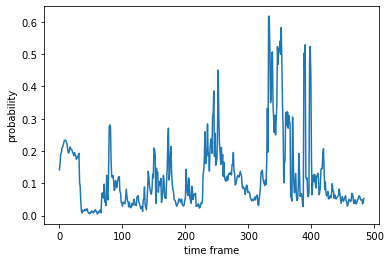

In [44]:
plt.xlabel('time frame')
plt.ylabel('probability')

plt.plot(all_probs)

### ИГРЫ

In [278]:
a = torch.rand((3, 40, 41))   # картинка 40 x 41
a = a.unsqueeze(1)
a.size()

torch.Size([3, 1, 40, 41])

In [264]:
kernel_size = (20, 5)
stride = (8, 2)

in_size = 1
out_size = 32

#### NORMAL

In [265]:
a.size()

torch.Size([3, 1, 40, 41])

In [266]:
conv2d = nn.Conv2d(in_size, out_size, kernel_size=(20, 5), stride=(8, 2))

In [267]:
conv2d(a).size()

torch.Size([3, 32, 3, 19])

#### SEPARABLE

In [268]:
a.size()

torch.Size([3, 1, 40, 41])

In [269]:
depth_w = nn.Conv2d(in_size, in_size, kernel_size, 
                             stride=stride, groups=in_size)
point_w = nn.Conv2d(in_size, out_size, kernel_size=1)

In [270]:
depth_res = depth_w(a)
print(depth_res.size())

res = point_w(depth_res)
print(res.size())

torch.Size([3, 1, 3, 19])
torch.Size([3, 32, 3, 19])


In [271]:
count_parameters(conv2d)

3232

In [272]:
count_parameters(depth_w) + count_parameters(point_w)

165

### ОНО???

In [496]:
a = torch.rand((3, 40, 41))   # картинка 40 x 41
a.size()

torch.Size([3, 40, 41])

Бегаем вправо-влево по картинке 40x41 окошком 5x1, таких окошек 40, для каждой строчки.

In [497]:
layer = nn.Conv1d(40, 40, kernel_size=5, groups=40, stride=2)

In [498]:
res1 = layer(a)
print(res1.size())

torch.Size([3, 40, 19])


Бегаем вправо-влево по картинке 40x? окошком 20x1, а 20 берется из 40/groups=20. При этом глубину выставляем 32, это все предыдущее предложение просто проделывается 32 раза.

In [370]:
layer2 = nn.Conv1d(40, 32, kernel_size=1, groups=2, stride=8)

In [371]:
res2 = layer2(res1)
print(res2.shape)

torch.Size([3, 32, 3])


### КОНЕЦ ИГР